In [ ]:
# default_exp pipeline

# Module pipeline

> Here we have the Nodes wrapping around our core functions, which can be added to a Nipype workflow to process your input images. These definitions here are our custom functions and Nipype Nodes knotted together, which creates a working pipeline.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#exporti
import os, sys
from shutil import which
from pathlib import Path

import pipetography.core as ppt
import pipetography.nodes as nodes

from nipype import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.mrtrix3.utils import BrainMask, TensorMetrics, DWIExtract, MRMath
from nipype.interfaces.mrtrix3.preprocess import MRDeGibbs, DWIBiasCorrect
from nipype.interfaces.mrtrix3.reconst import FitTensor
from nipype.interfaces import ants
from nipype.interfaces import fsl

## Preprocessing `pipeline` module:

A class containing `core` functionalities wrapped in a `Nipype` workflow, assuming your input data is in valid BIDS format. This pipeline will follow the [DESIGNER] protocol and align your T1 & DWI to MNI template space (ACPC HCP procedure), perform all denoising & artifact removal steps, and correct the DWI gradients accordingly.

In [ ]:
# export
class pipeline:
    """
    Create `core` functionality nodes for a `Nipype` workflow that selects data inputs iteratively from `BIDS_dir` that has both `anat` and `dwi` modalities,
    you will need to specify the reverse phase encoding design of your dwi acquisition with `RPE_design`, and declare whether you want to re-sample your dwi
    voxels to MNI 1mm voxel grids (by default `Regrid = False`). Lastly, you can specify how many threads you want `mrtrix3` functions to have, by default,
    `mrtrix_nthreads = 0`, meaning multi-threading is disabled. Multi-threading is different from parallel processing, the threads work in individual cores.
    """

    def __init__(self, BIDS_dir="data", ext = "nii.gz", RPE_design="-rpe_none", Regrid=True, recon = True, mrtrix_nthreads=0):
        """
        Nodes are initialized with the bare minimum of inputs or default parameters
        Remaining inputs are either connected in the Nipype workflow or are user inputs
        Args:
            - BIDS_dir (str): Path to BIDS dataset
            - RPE_design (str): see mrtrix3 docs for options, "-rpe_none" is default.
            - Regrid (bool): whether to resample your dwi to MNI template 1mm voxel grids
            - recon (bool): whether to perform freesurfer's recon-all
            - mrtrix_nthreads (int): how many threads to use for mrtrix3 functions
        """
        self.bids_dir = BIDS_dir
        self.RPE_design = RPE_design
        self.Regrid = Regrid
        self.recon = recon
        self.mrtrix_nthreads = mrtrix_nthreads
        self.ext = ext
        self.MNI_template = os.path.expandvars('$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz')
        # Create derivatives folder if it doesn't exist:
        if not os.path.exists(os.path.join(BIDS_dir, '..', 'derivatives')):
            print('No derivatives folder, creating it at {}'.format(
                os.path.join(Path(BIDS_dir).parent, 'derivatives'))
                 )
            os.makedirs(os.path.join(Path(BIDS_dir).parent, 'derivatives'))
        elif os.path.exists(os.path.join(Path(BIDS_dir).parent, 'derivatives')):
            print('derivatives folder found at {}'.format(os.path.join(Path(BIDS_dir).parent, 'derivatives')))
        # Generate BIDS Layout, and create subject ID list:
        self.sub_list, self.layout = ppt.get_subs(self.bids_dir)
        # string templates for images: the templates will depend on rpe_design:
        #  - rpe_none: anat_file, dwi_file, b_files
        #  - rpe_all/rpe_pair: anat_file, dwi_file, rdwi_file, b_files, rb_files
        if RPE_design == '-rpe_none':
            self.anat_file = os.path.join(
                'sub-{subject_id}', 'ses-*', 'anat', 'sub-{subject_id}_ses-*_T1w.{ext}'
            )
            self.dwi_file = os.path.join(
                "sub-{subject_id}", "ses-*", "dwi", "sub-{subject_id}_ses-*_dwi.{ext}",
            )
            self.b_files = os.path.join(
                "sub-{subject_id}", "ses-*", "dwi", "sub-{subject_id}_ses-*_dwi.bv*"
            )
        elif RPE_design == '-rpe_all':
            # if all directions were acquired twice, with reverse phase encoding directions.
            self.anat_file = os.path.join(
                'sub-{subject_id}', 'ses-*', 'anat', 'sub-{subject_id}_ses-*_T1w.{ext}'
            )
            self.dwi_file = os.path.join(
                "sub-{subject_id}", "ses-*", "dwi", "sub-{subject_id}_ses-*_run-1_dwi.{ext}",
            )
            self.b_files = os.path.join(
                "sub-{subject_id}", "ses-*", "dwi", "sub-{subject_id}_ses-*_run-1_dwi.bv*"
            )
            self.rdwi_file = os.path.join(
                "sub-{subject_id}", "ses-*", "dwi", "sub-{subject_id}_ses-*_run-2_dwi.{ext}",
            )
            self.rb_files = os.path.join(
                "sub-{subject_id}", "ses-*", "dwi", "sub-{subject_id}_ses-*_run-2_dwi.bv*"
            )

    def create_nodes(self):
        if self.RPE_design == '-rpe_none':
            self.sub_template = {
                "anat": self.anat_file,
                "dwi": self.dwi_file,
                "b_files": self.b_files
            }
        elif self.RPE_design == '-rpe_all':
            self.sub_template = {
                "anat": self.anat_file,
                "dwi": self.dwi_file,
                "bfiles": self.b_files,
                "rdwi": self.rdwi_file,
                "rbfiles": self.rb_files
            }
        self.PreProcNodes = nodes.PreProcNodes(bids_dir=self.bids_dir, bids_path_template=self.sub_template, bids_ext = self.ext, sub_list=self.sub_list, RPE_design=self.RPE_design)
        self.PreProcNodes.set_inputs(bids_dir=self.bids_dir, bids_ext = self.ext, RPE_design=self.RPE_design, mrtrix_nthreads=self.mrtrix_nthreads)
        self.ACPCNodes = nodes.ACPCNodes(MNI_template=self.MNI_template)
        self.ACPCNodes.set_inputs(bids_dir=self.bids_dir, MNI_template=self.MNI_template)
        self.workflow = None


    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
    def check_environment(self):
        """
        Check your computing environment for FSL environment variables `FSLOUTPUTTYPE` and `FSLDIR`
        Check if ANTs PATH is included in your environment
        Check if mrtrix3 is in your PATH
        Check your freesurfer envrionment variable
        Looks for matlab compiler run time in freesurfer directory: https://surfer.nmr.mgh.harvard.edu/fswiki/MatlabRuntime
        """
        assert "FSLOUTPUTTYPE" in os.environ
        assert "FSLDIR" in os.environ
        if "FSLOUTPUTTYPE" in os.environ:
            print("FSLOUTPUTTYPE is valid")
        else:
            sys.exit("FSLOUTPUTTYPE is not defined, make sure FSL is configured!")

        if "FSLDIR" in os.environ:
            print("FSLDIR is valid")
        else:
            sys.exit("FSLOUTPUTTYPE is not defined, make sure FSL is configured!")
        #ANTS:
        assert "ANTSPATH" in os.environ
        print("ANTS is valid")
        #mrtrix:
        assert which('dwifslpreproc') is not None
        print("mrtrix3 is valid")
        #freesurfer:
        assert "FREESURFER_HOME" in os.environ
        print("Freesurfer path found")
        #matlab compiler run time
        assert os.path.isdir(os.path.expandvars('$FREESURFER_HOME/MCRv80'))
        print('Matlab Compiler Runtime 2012 version in Freesurfer Path found. (MCRv80)')
        return None


    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
    # Connect the nodes we defined above into a workflow:
    def connect_nodes(self, RPE_design, recon=True, Regrid=True, wf_name="pipetography"):
        """
        Connect nodes one by one and create Nipype workflow
        Input: wfname (str): name your workflow, default is pipetography
        """
        # a workflow that will be filled in with connections:
        self.workflow = Workflow(name=wf_name, base_dir=os.path.join(Path(self.bids_dir).parent, 'derivatives'))
        # connections:
        self.workflow.connect(
            [
                (self.PreProcNodes.subject_source, self.PreProcNodes.select_files, [('subject_id', 'subject_id')]),
                (self.PreProcNodes.select_files, self.ACPCNodes.reduceFOV, [("anat", "in_file")]),
                (self.PreProcNodes.select_files, self.ACPCNodes.ACPC_warp, [("anat", "in_file")]),
                (self.ACPCNodes.reduceFOV, self.ACPCNodes.xfminverse, [("out_transform", "in_file")]),
                (self.ACPCNodes.xfminverse, self.ACPCNodes.concatxfm, [("out_file", "in_file")]),
                (self.ACPCNodes.reduceFOV, self.ACPCNodes.flirt, [("out_roi", "in_file")]),
                (self.ACPCNodes.flirt, self.ACPCNodes.concatxfm, [("out_matrix_file", "in_file2")]),
                (self.ACPCNodes.concatxfm, self.ACPCNodes.alignxfm, [("out_file", "in_file")]),
                (self.ACPCNodes.alignxfm, self.ACPCNodes.ACPC_warp, [("out_file", "premat")]),
                (self.ACPCNodes.ACPC_warp, self.PreProcNodes.datasink, [("out_file", "t1_acpc_aligned")]),
                (self.ACPCNodes.ACPC_warp, self.ACPCNodes.t1_bet, [("out_file", "in_file")]),
                (self.ACPCNodes.ACPC_warp, self.ACPCNodes.epi_reg, [("out_file", "t1_head")]),
                (self.ACPCNodes.t1_bet, self.ACPCNodes.epi_reg, [("out_file", "t1_brain")]),
                (self.PreProcNodes.sub_apply_mask, self.ACPCNodes.epi_reg, [("out_file", "epi")]),
                (self.ACPCNodes.epi_reg, self.ACPCNodes.acpc_xfm, [("epi2str_mat", "flirt_xfm")]),
                (self.PreProcNodes.sub_apply_mask, self.ACPCNodes.acpc_xfm, [("out_file", "flirt_in")]),
                (self.ACPCNodes.t1_bet, self.ACPCNodes.acpc_xfm, [("out_file", "flirt_ref")]),
                (self.ACPCNodes.acpc_xfm, self.ACPCNodes.apply_xfm, [("out_file", "linear_xfm")]),
                (self.PreProcNodes.norm_intensity, self.ACPCNodes.apply_xfm, [("out_file", "in_file")]),
                (self.PreProcNodes.select_files, self.PreProcNodes.get_metadata, [("dwi", "path")]),
                (self.PreProcNodes.get_metadata, self.PreProcNodes.fslpreproc, [("ReadoutTime", "RO_time"),
                                                                                ("PE_DIR", "pe_dir")]),
                (self.PreProcNodes.createMask, self.PreProcNodes.GradCheck, [('out_file', 'mask_file')]),
                (self.PreProcNodes.GradCheck, self.PreProcNodes.NewGradMR, [('out_bfile', 'grad_file')]),
                (self.PreProcNodes.NewGradMR, self.PreProcNodes.denoise, [('out_file', 'in_file')]),
                (self.PreProcNodes.denoise, self.PreProcNodes.degibbs, [('out_file', 'in_file')]),
                (self.PreProcNodes.degibbs, self.PreProcNodes.fslpreproc, [('out_file', 'in_file')]),
                (self.PreProcNodes.GradCheck, self.PreProcNodes.fslpreproc, [('out_bfile', 'grad_file')]),
                (self.PreProcNodes.fslpreproc, self.PreProcNodes.GradUpdate, [('out_file', 'in_file')]),
                (self.PreProcNodes.fslpreproc, self.PreProcNodes.ModGrad, [('out_file',  'in_file')]),
                (self.PreProcNodes.GradUpdate, self.PreProcNodes.ModGrad, [('out_bfile', 'grad_file')]),
                (self.PreProcNodes.ModGrad, self.PreProcNodes.UpdateMif, [('out_bfile', 'grad_file')]),
                (self.PreProcNodes.fslpreproc, self.PreProcNodes.UpdateMif, [('out_file', 'in_file')]),
                (self.PreProcNodes.UpdateMif, self.PreProcNodes.NewMask, [("out_file", 'in_file')]),
                (self.PreProcNodes.ModGrad, self.PreProcNodes.NewMask, [("out_bfile", "grad_file")]),
                (self.PreProcNodes.UpdateMif, self.PreProcNodes.biascorrect, [("out_file", "in_file")]),
                (self.PreProcNodes.ModGrad, self.PreProcNodes.biascorrect, [("out_bfile", "grad_file")]),
                (self.PreProcNodes.NewMask, self.PreProcNodes.biascorrect, [("out_file", "in_mask")]),
                (self.PreProcNodes.biascorrect, self.PreProcNodes.grad_info, [("out_file", "in_file")]),
                (self.PreProcNodes.ModGrad, self.PreProcNodes.grad_info, [("out_bfile", "grad_file")]),
                (self.PreProcNodes.denoise, self.PreProcNodes.low_noise_map, [("noise", "isfinite")]),
                (self.PreProcNodes.denoise, self.PreProcNodes.low_noise_map, [("noise", "cond_if")]),
                (self.PreProcNodes.low_noise_map, self.PreProcNodes.rician_noise, [("out_file", "lownoisemap")]),
                (self.PreProcNodes.biascorrect, self.PreProcNodes.rician_noise, [("out_file", "in_file")]),
                (self.PreProcNodes.rician_noise, self.PreProcNodes.check_rician, [("out_file", "isfinite")]),
                (self.PreProcNodes.rician_noise, self.PreProcNodes.check_rician, [("out_file", "cond_if")]),
                (self.PreProcNodes.check_rician, self.PreProcNodes.convert_rician, [("out_file", "in_file")]),
                (self.PreProcNodes.grad_info, self.PreProcNodes.convert_rician, [("out_bfile", "grad_file")]),
                (self.PreProcNodes.convert_rician, self.PreProcNodes.dwi_mask, [("out_file", "in_file")]),
                (self.PreProcNodes.dwi_mask, self.PreProcNodes.fit_tensor, [("out_file", "in_mask")]),
                (self.PreProcNodes.convert_rician, self.PreProcNodes.fit_tensor, [("out_file", "in_file")]),
                (self.PreProcNodes.fit_tensor, self.PreProcNodes.tensor_FA, [("out_file", "in_file")]),
                (self.PreProcNodes.tensor_FA, self.PreProcNodes.wm_mask, [("out_fa", "in_file")]),
                (self.PreProcNodes.wm_mask, self.PreProcNodes.norm_intensity, [("out_file", "mask_file")]),
                (self.PreProcNodes.convert_rician, self.PreProcNodes.norm_intensity, [("out_file", "in_file")]),
                (self.PreProcNodes.norm_intensity, self.PreProcNodes.sub_b0extract, [("out_file", "in_file")]),
                (self.PreProcNodes.sub_b0extract, self.PreProcNodes.sub_b0mean, [("out_file", "in_file")]),
                (self.PreProcNodes.norm_intensity, self.PreProcNodes.sub_b0mask, [("out_file", "in_file")]),
                (self.PreProcNodes.sub_b0mask, self.PreProcNodes.sub_convert_mask, [("out_file", "in_file")]),
                (self.PreProcNodes.sub_b0mean, self.PreProcNodes.sub_convert_dwi, [("out_file", "in_file")]),
                (self.PreProcNodes.sub_convert_dwi, self.PreProcNodes.sub_apply_mask, [("out_file", "in_file")]),
                (self.PreProcNodes.sub_convert_mask, self.PreProcNodes.sub_apply_mask, [("out_file", "mask_file")]),
                (self.PreProcNodes.mni_b0extract, self.PreProcNodes.mni_b0mean, [("out_file", "in_file")]),
                (self.PreProcNodes.mni_b0mask, self.PreProcNodes.mni_convert_mask, [("out_file", "in_file")]),
                (self.PreProcNodes.mni_b0mean, self.PreProcNodes.mni_convert_dwi, [("out_file", "in_file")]),
                (self.PreProcNodes.mni_convert_mask, self.PreProcNodes.mni_apply_mask, [("out_file", "mask_file")]),
                (self.PreProcNodes.mni_convert_dwi, self.PreProcNodes.mni_apply_mask, [("out_file", "in_file")]),
                (self.PreProcNodes.mni_apply_mask, self.PreProcNodes.datasink, [("out_file", "preproc_mni.@dwi_brain")]),
                (self.PreProcNodes.mni_convert_mask, self.PreProcNodes.datasink, [("out_file", "preproc_mni.@dwi_b0_brainmask")]),
                (self.PreProcNodes.mni_convert_dwi, self.PreProcNodes.datasink, [("out_file", "preproc_mni.@dwi_b0_meanvolume")]),
                (self.PreProcNodes.mni_dwi, self.PreProcNodes.datasink, [("out_file", "preproc_mni.@dwi")]),
                (self.PreProcNodes.mni_dwi, self.PreProcNodes.datasink, [("out_bfile", "preproc_mni.@b")]),
                (self.PreProcNodes.mni_dwi, self.PreProcNodes.datasink, [("out_fslbvec", "preproc_mni.@fsl_bvec")]),
                (self.PreProcNodes.mni_dwi, self.PreProcNodes.datasink, [("out_fslbval", "preproc_mni.@fsl_bval")]),
                (self.PreProcNodes.mni_dwi, self.PreProcNodes.datasink, [("out_json", "preproc_mni.@json")])
            ]
        )
        if recon == True:
            self.workflow.connect(
                [
                    (self.PreProcNodes.select_files, self.ACPCNodes.get_fs_id,  [("anat", "anat_files")]),
                    (self.ACPCNodes.ACPC_warp, self.ACPCNodes.reconall, [("out_file", "T1_files")]),
                    (self.ACPCNodes.get_fs_id, self.ACPCNodes.reconall, [("fs_id_list", "subject_id")]),

                ]
            )
        if RPE_design == '-rpe_none':
            self.workflow.connect(
                [
                    (self.PreProcNodes.select_files, self.PreProcNodes.mrconvert, [('dwi', 'in_file')]),
                    (self.PreProcNodes.select_files, self.PreProcNodes.sub_grad_files, [('dwi', 'sub_dwi')]),
                    (self.PreProcNodes.sub_grad_files, self.PreProcNodes.mrconvert, [('fslgrad', 'grad_fsl')]),
                    (self.PreProcNodes.mrconvert, self.PreProcNodes.createMask, [('out_file', 'in_file')]),
                    (self.PreProcNodes.mrconvert, self.PreProcNodes.GradCheck, [('out_file', 'in_file')]),
                    (self.PreProcNodes.mrconvert, self.PreProcNodes.GradCheck, [('out_bfile', 'grad_file')]),
                    (self.PreProcNodes.mrconvert, self.PreProcNodes.NewGradMR, [('out_file', 'in_file')]),
                    (self.PreProcNodes.fslpreproc, self.PreProcNodes.GradUpdate, [('out_bfile', 'grad_file')])
                ]
            )
        elif RPE_design == '-rpe_all':
            self.workflow.connect(
                [
                    (self.PreProcNodes.select_files, self.PreProcNodes.sub_grad_files1, [('dwi', 'sub_dwi')]),
                    (self.PreProcNodes.select_files, self.PreProcNodes.sub_grad_files2, [('rdwi', 'sub_dwi')]),
                    (self.PreProcNodes.select_files, self.PreProcNodes.mrconvert1, [('dwi', 'in_file')]),
                    (self.PreProcNodes.select_files, self.PreProcNodes.mrconvert2, [('rdwi', 'in_file')]),
                    (self.PreProcNodes.sub_grad_files1, self.PreProcNodes.mrconvert1, [('fslgrad', 'grad_fsl')]),
                    (self.PreProcNodes.sub_grad_files2, self.PreProcNodes.mrconvert2, [('fslgrad', 'grad_fsl')]),
                    (self.PreProcNodes.mrconvert1, self.PreProcNodes.mrconcat, [('out_file', 'image1')]),
                    (self.PreProcNodes.mrconvert2, self.PreProcNodes.mrconcat, [('out_file', 'image2')]),
                    (self.PreProcNodes.mrconvert1, self.PreProcNodes.gradcat, [('out_bfile', 'grad1')]),
                    (self.PreProcNodes.mrconvert2, self.PreProcNodes.gradcat, [('out_bfile', 'grad2')]),
                    (self.PreProcNodes.mrconcat, self.PreProcNodes.createMask, [('out_file', 'in_file')]),
                    (self.PreProcNodes.mrconcat, self.PreProcNodes.GradCheck, [('out_file', 'in_file')]),
                    (self.PreProcNodes.gradcat, self.PreProcNodes.GradCheck, [('out_file', 'grad_file')]),
                    (self.PreProcNodes.mrconcat, self.PreProcNodes.NewGradMR, [('out_file', 'in_file')]),
                    (self.PreProcNodes.mrconvert1, self.PreProcNodes.GradUpdate, [('out_bfile', 'grad_file')])
                ]
            )
        if Regrid == True:
            self.workflow.connect(
                [
                    (self.ACPCNodes.apply_xfm, self.ACPCNodes.regrid, [("out_file", "in_file")]),
                    (self.ACPCNodes.regrid, self.PreProcNodes.datasink, [("out_file", "dwi_acpc_aligned_1mm")]),
                    (self.ACPCNodes.regrid, self.PreProcNodes.mni_b0extract, [("out_file", "in_file")]),
                    (self.ACPCNodes.regrid, self.PreProcNodes.mni_b0mask, [("out_file", "in_file")]),
                    (self.ACPCNodes.regrid, self.PreProcNodes.mni_dwi, [("out_file", "in_file")])
                ]
            )
        elif Regrid == False:
            self.workflow.connect(
                [
                    (self.ACPCNodes.apply_xfm, self.PreProcNodes.mni_b0extract, [("out_file", "in_file")]),
                    (self.ACPCNodes.apply_xfm, self.PreProcNodes.mni_b0mask, [("out_file", "in_file")]),
                    (self.ACPCNodes.apply_xfm, self.PreProcNodes.mni_dwi, [("out_file", "in_file")])
                ]
            )
        self.workflow.config['execution'] = {
                                            'use_relative_paths':'False',
                                            'hash_method': 'content',
                                            'stop_on_first_crash': 'True',
                                            }


    def draw_pipeline(self):
        self.workflow.write_graph(graph2use='orig', dotfilename = 'pipetography.dot')


    def run_pipeline(self, parallel = None):
        if type(parallel) == int:
            print("Running workflow with {} parallel processes".format(parallel))
            self.workflow.run('MultiProc', plugin_args = {'n_procs': parallel})
        elif parallel is None:
            print("Parallel processing is not enabled, running workflow serially.")
            self.workflow.run()

In [ ]:
#test

wf_1 = pipeline(BIDS_dir='data')
assert wf_1.bids_dir == 'data'
assert wf_1.RPE_design == '-rpe_none'
assert wf_1.Regrid == True
assert wf_1.recon == True
assert wf_1.ext == 'nii.gz'
assert wf_1.MNI_template == os.path.expandvars('$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz')
assert wf_1.layout.get_subjects() == wf_1.sub_list
wf_1.create_nodes()
wf_1.connect_nodes(RPE_design='-rpe_none')

wf_2 = pipeline(BIDS_dir='data', ext='nii', RPE_design='-rpe_all')
assert wf_2.RPE_design == '-rpe_all'
assert wf_2.ext == 'nii'
wf_2.create_nodes()
wf_2.connect_nodes(RPE_design='-rpe_all')

derivatives folder found at ./derivatives
Creating layout of data directory, might take a while if there are a lot of subjects
FSLOUTPUTTYPE is valid
FSLDIR is valid
ANTS is valid
mrtrix3 is valid
Freesurfer path found
Matlab Compiler Runtime 2012 version in Freesurfer Path found. (MCRv80)
Data sink (output folder) is set to ./derivatives
Freesurfer output at ./derivatives/freesurfer


/Users/xxie/miniconda3/envs/tracts/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


### Example:

Create a `pipeline`:

In [ ]:
#example
preproc_dwi = pipeline(BIDS_dir='/Users/xxie/sample_data/tinnitus2/', ext = 'nii', RPE_design='-rpe_all', Regrid=True, mrtrix_nthreads=8)

derivatives folder found at /Users/xxie/sample_data/derivatives
Creating layout of data directory, might take a while if there are a lot of subjects


Check if our environment is properly set-up:

In [ ]:
#example
preproc_dwi.check_environment()

FSLOUTPUTTYPE is valid
FSLDIR is valid
ANTS is valid
mrtrix3 is valid
Freesurfer path found
Matlab Compiler Runtime 2012 version in Freesurfer Path found. (MCRv80)


Take a look at what's in the `pipeline`:

In [ ]:
#example
preproc_dwi.__dict__

{'bids_dir': '/Users/xxie/sample_data/tinnitus2/',
 'RPE_design': '-rpe_all',
 'Regrid': True,
 'recon': True,
 'mrtrix_nthreads': 8,
 'ext': 'nii',
 'MNI_template': '/usr/local/fsl/data/standard/MNI152_T1_1mm.nii.gz',
 'sub_list': ['MINN294'],
 'layout': BIDS Layout: ...ers/xxie/sample_data/tinnitus2 | Subjects: 1 | Sessions: 1 | Runs: 3,
 'anat_file': 'sub-{subject_id}/ses-*/anat/sub-{subject_id}_ses-*_T1w.{ext}',
 'dwi_file': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-1_dwi.{ext}',
 'b_files': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-1_dwi.bv*',
 'rdwi_file': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-2_dwi.{ext}',
 'rb_files': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-2_dwi.bv*'}

We can tweak some things in the pipeline (this is totally not necessary if your BIDS dataset follows conventional naming), for example, to fit the subject file template strings to match our dataset naming scheme:

In [ ]:
#example
preproc_dwi.anat_file = 'sub-{subject_id}/ses-*/anat/sub-{subject_id}_ses-*_run-1_T1w.nii'
preproc_dwi.dwi_file = 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-1_dwi.nii'
preproc_dwi.rdwi_file = 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-2_dwi.nii'

# now that our anatomy & dwi file templates are correct, we can initiate our nodes:
preproc_dwi.create_nodes()

preproc_dwi.__dict__

Data sink (output folder) is set to /Users/xxie/sample_data/derivatives
Freesurfer output at /Users/xxie/sample_data/derivatives/freesurfer


{'bids_dir': '/Users/xxie/sample_data/tinnitus2/',
 'RPE_design': '-rpe_all',
 'Regrid': True,
 'recon': True,
 'mrtrix_nthreads': 8,
 'ext': 'nii',
 'MNI_template': '/usr/local/fsl/data/standard/MNI152_T1_1mm.nii.gz',
 'sub_list': ['MINN294'],
 'layout': BIDS Layout: ...ers/xxie/sample_data/tinnitus2 | Subjects: 1 | Sessions: 1 | Runs: 3,
 'anat_file': 'sub-{subject_id}/ses-*/anat/sub-{subject_id}_ses-*_run-1_T1w.nii',
 'dwi_file': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-1_dwi.nii',
 'b_files': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-1_dwi.bv*',
 'rdwi_file': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-2_dwi.nii',
 'rb_files': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-2_dwi.bv*',
 'sub_template': {'anat': 'sub-{subject_id}/ses-*/anat/sub-{subject_id}_ses-*_run-1_T1w.nii',
  'dwi': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-1_dwi.nii',
  'bfiles': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_run-1_dwi.bv*',
  'rdwi

We can set up preprocessing pipeline with default parameters, this will connect all workflow nodes with default input names and parameter values:

In [ ]:
#example
#usage
preproc_dwi.connect_nodes(RPE_design='-rpe_all')

All the default settings may not be optimal for your dataset, run the processing for a test image and see the intermediate results and then tweak the available inputs to improve the output image quality.

Now that our pre-processing Nodes are properly setup, we can visualize our workflow:

In [ ]:
#example
#preproc_dwi.connect_nodes(wf_name = 'pipetography')
preproc_dwi.draw_pipeline()

200702-10:47:20,924 nipype.workflow INFO:
	 Generated workflow graph: /Users/xxie/sample_data/derivatives/pipetography/pipetography.png (graph2use=orig, simple_form=True).


Let's take a look at the final workflow we created:

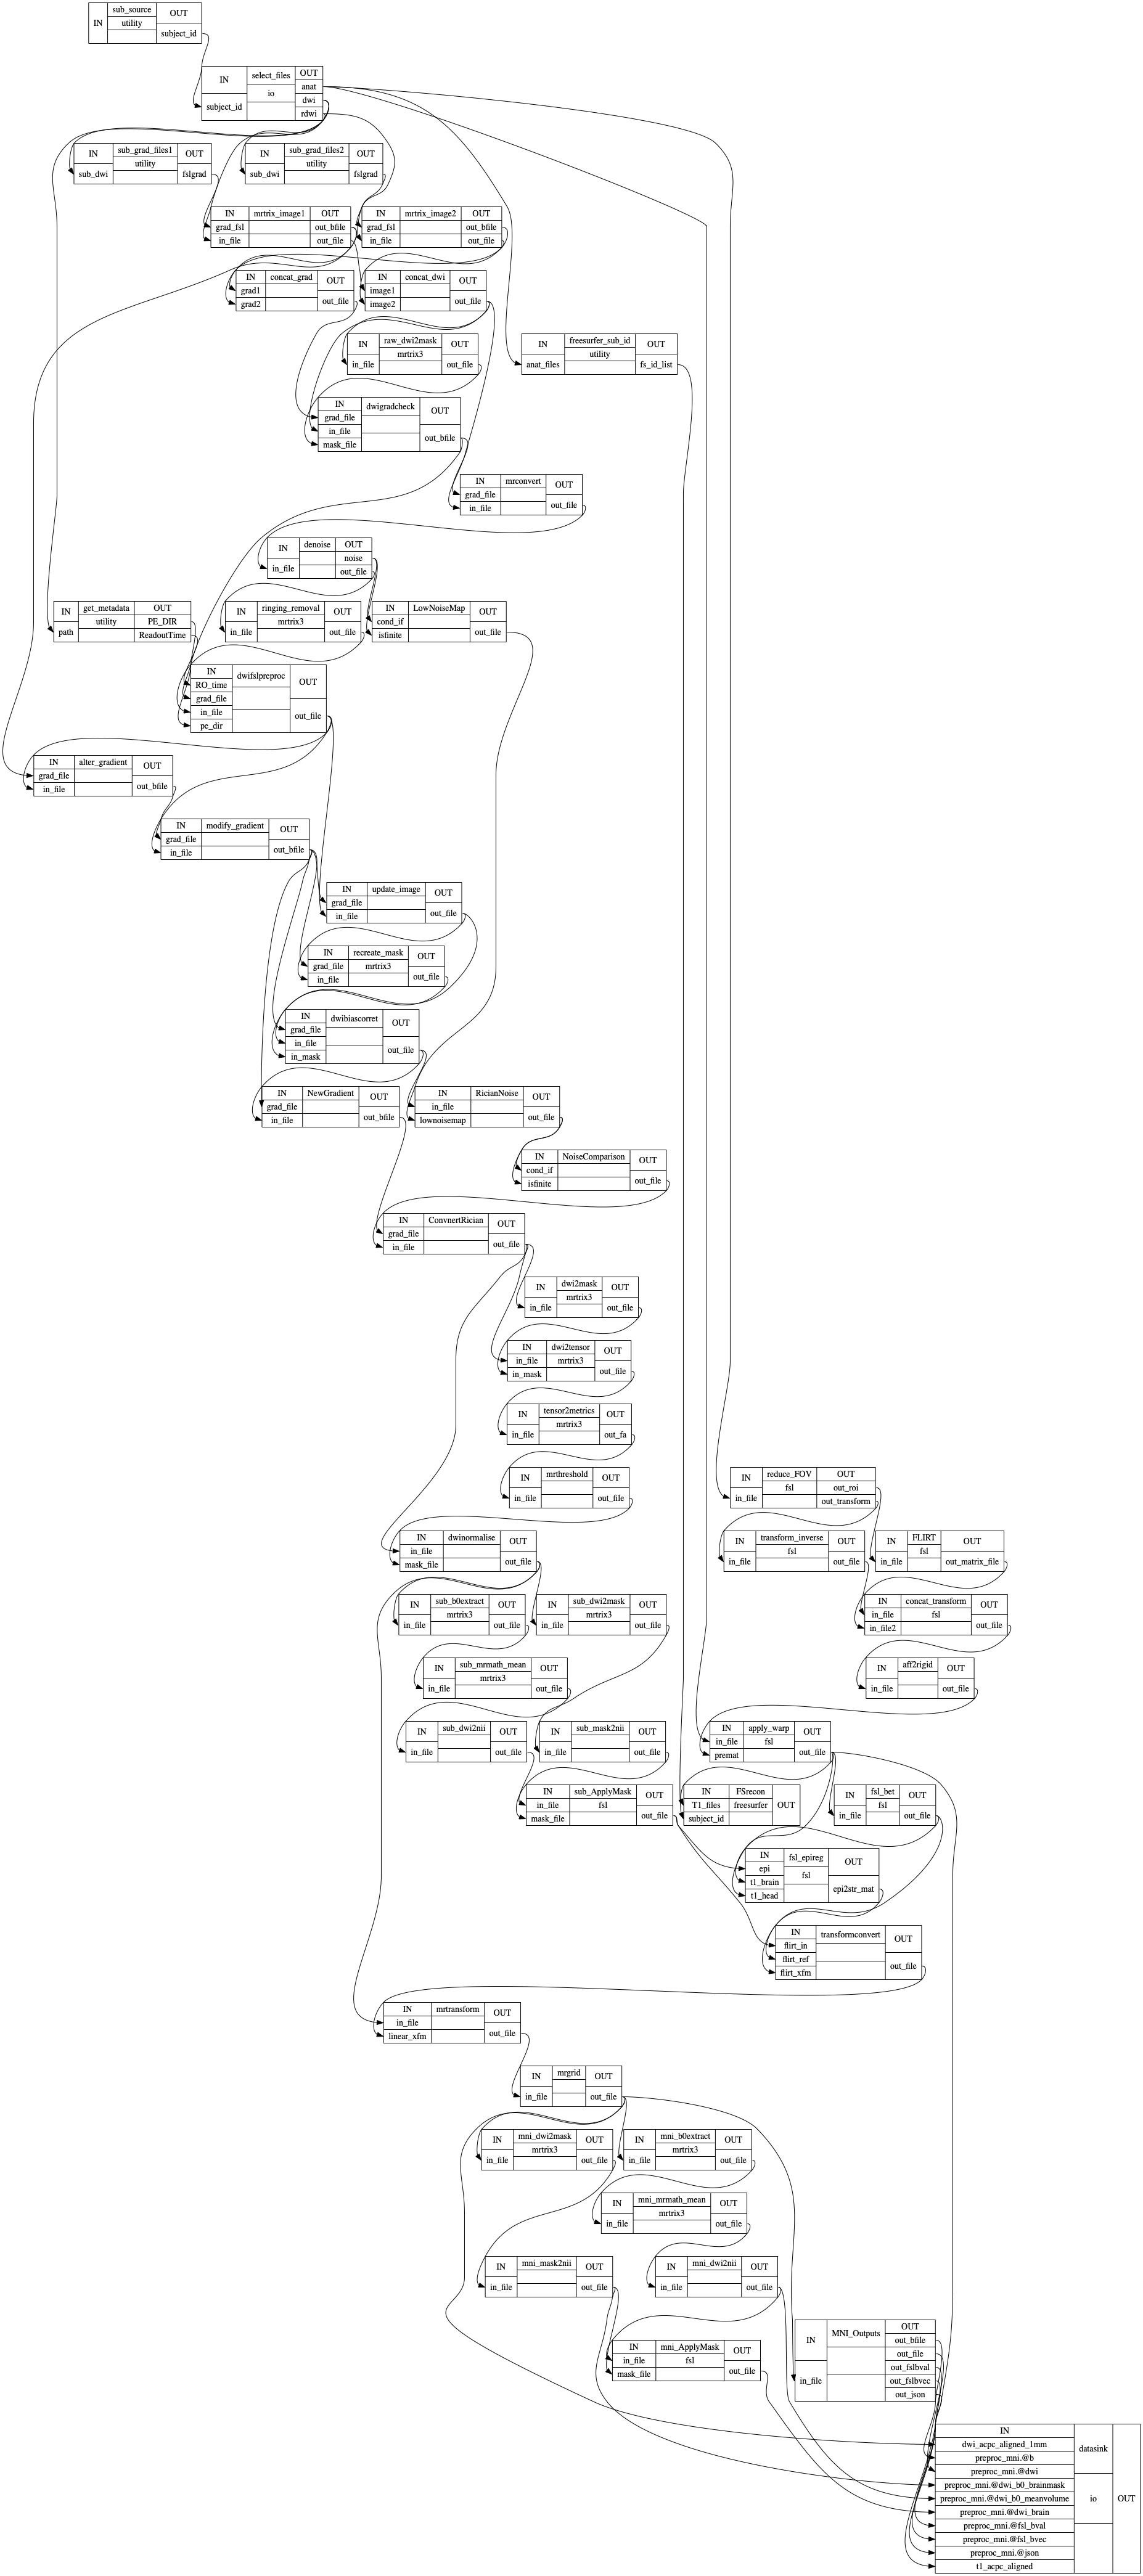

In [ ]:
#example
from IPython.display import Image
Image('/Users/xxie/sample_data/derivatives/pipetography/pipetography_detailed.png')

### Run pipeline:

Calling `run_pipeline` will prompt an user input for the number of parallel processes 

In [ ]:
#example
preproc_dwi.run_pipeline(parallel = 4)

Running workflow with 4 parallel processes
200702-10:48:04,707 nipype.workflow INFO:
	 Workflow pipetography settings: ['check', 'execution', 'logging', 'monitoring']
200702-10:48:04,762 nipype.workflow INFO:
	 Running in parallel.
200702-10:48:04,767 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.80/28.80, Free processors: 4/4.
200702-10:48:04,868 nipype.workflow INFO:
	 [Node] Setting-up "pipetography.select_files" in "/Users/xxie/sample_data/derivatives/pipetography/_subject_id_MINN294/select_files".
200702-10:48:04,881 nipype.workflow INFO:
	 [Node] Running "select_files" ("nipype.interfaces.io.SelectFiles")
200702-10:48:04,902 nipype.workflow INFO:
	 [Node] Finished "pipetography.select_files".
200702-10:48:06,770 nipype.workflow INFO:
	 [Job 0] Completed (pipetography.select_files).
200702-10:48:06,774 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 28.80/28.80, Free processors: 4/4.
200702-10:4

## Outputs:

The datasink node will automatically create a derivatives folder in the parent BIDS directory folder if it doesn't find a derivatives folder. The `derivatives` directory will contain the follwoing after running the pipeline:

In [ ]:
#example
!tree /Users/xxie/sample_data/derivatives/ -L 2

/Users/xxie/sample_data/derivatives/
├── dwi_acpc_aligned_1mm
│   └── _subject_id_MINN294
├── freesurfer
│   ├── fsaverage -> /Applications/freesurfer/subjects/fsaverage
│   └── sub-MINN294_ses-01
├── pipetography
│   ├── _subject_id_MINN294
│   ├── d3.js
│   ├── graph.json
│   ├── graph1.json
│   ├── index.html
│   ├── pipetography.dot
│   ├── pipetography.png
│   ├── pipetography_detailed.dot
│   └── pipetography_detailed.png
├── preproc_mni
│   └── _subject_id_MINN294
└── t1_acpc_aligned
    └── _subject_id_MINN294

11 directories, 8 files


 - `freesurfer`: this is the freesurfer `recon-all` outputs for each subject and session
 - `pipetography`: this contains all workflow node's outputs, log files, and reports.
 - `dwi_acpc_alignned_1mm`: data sink output if `regrid` was set to `True`, this contains the DWI image that's been resampled to match the voxel grid of the MNI template.
 - `t1_acpc_aligned`: T1 images that were aligned to the MNI template.
 - `preproc_mni`: Final DWI images including mean B0 volumes, B0 brain masks, B0 brain volumes, and preprocessed DWI in MNI space.